# 03: Feature transformation & selection

### Import

In [11]:
import numpy as np
import pandas as pd

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data
We use [a dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) from Kaggle.
It contains 81 features describing sold houses. 
The features describe house locations, its physical attributes and sales information.
See data_description.txt for more details.

We want to predict the sale prices (SalePrice column) based on the remaining 80 features. (Sometimes called the 'target' variable.)

In [12]:
df = pd.read_csv('data.csv')
#df.info()

Brief cleaning first.

In [13]:
# Convert all object values to categorial format
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')
# Fill all NaN with 0
df.loc[:,df.select_dtypes(include=['float64']).columns] = df.loc[:,df.select_dtypes(include=['float64']).columns].fillna(0)

We now have several categorical features with some missings.

In [14]:
df.columns[df.isnull().any()]
# df.select_dtypes(include=['category']).columns

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

## Feature transformations

First, we focus on transformations that can help to increase the performance of prediction models.

Since we want to use the linear regression as a prediction model it is usually beneficial to convert categorical (especially nominal) variables into indicators.

In [15]:
# Convert categorical variables to indicators and create new data
df = pd.get_dummies(df)

# check that there are no missings now
df.columns[df.isnull().any()]

Index([], dtype='object')

Let us also convert all non-indicator values to float64 - which would be useful later.

In [16]:
df[df.select_dtypes(['float16', 'float64', 'int64']).columns] = df[df.select_dtypes(['float16', 'float64', 'int64']).columns].astype('float64')

In [17]:
df.dtypes.value_counts()

uint8      252
float64     37
dtype: int64

#### Sometimes it is useful to introduce new features based on the original ones

In [18]:
# Let us create new features as square roots of Area features - i.e. so they correspond to diameters of circles having the same area
# We also add indicators of zero values (usually missings) there
for column in df.filter(regex='Area|SF', axis=1).columns:  # SF - square foot which means area
    df['Has' + column] = (df[column] > 0).replace({True: 1, False: 0}).astype('uint8')
    df['Sqrt' + column] = np.sqrt(df[column])

print('Shape of the data:', df.shape)

Shape of the data: (1460, 319)


In [19]:
# See the results for Area features
df[df.filter(regex='Area', axis=1).columns].head()

,LotArea,MasVnrArea,GrLivArea,GarageArea,PoolArea,HasLotArea,SqrtLotArea,HasMasVnrArea,SqrtMasVnrArea,HasGrLivArea,SqrtGrLivArea,HasGarageArea,SqrtGarageArea,HasPoolArea,SqrtPoolArea
0,8450.0,196.0,1710.0,548.0,0.0,1,91.923882,1,14.000000,1,41.352146,1,23.409400,0,0.0
1,9600.0,0.0,1262.0,460.0,0.0,1,97.979590,0,0.000000,1,35.524639,1,21.447611,0,0.0
2,11250.0,162.0,1786.0,608.0,0.0,1,106.066017,1,12.727922,1,42.261093,1,24.657656,0,0.0
3,9550.0,0.0,1717.0,642.0,0.0,1,97.724101,0,0.000000,1,41.436699,1,25.337719,0,0.0
4,14260.0,350.0,2198.0,836.0,0.0,1,119.415242,1,18.708287,1,46.882833,1,28.913665,0,0.0


/home/ladislav/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


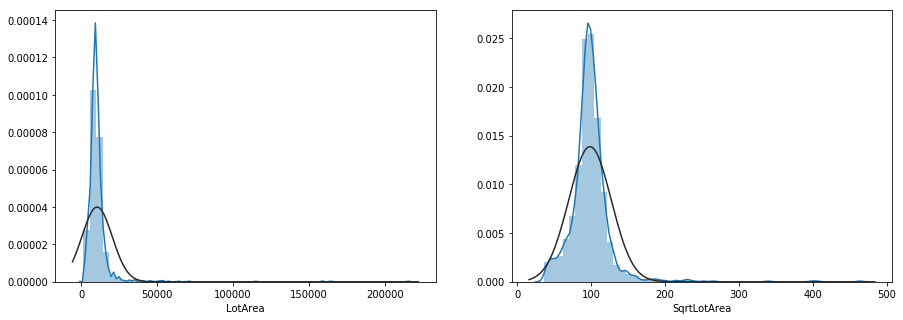

In [20]:
# Distribution visualisation
f, axes = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(df[df.LotArea>0].LotArea, fit = stats.norm, ax=axes[0])
sns.distplot(df[df.LotArea>0].SqrtLotArea, fit = stats.norm, ax=axes[1])

#### Constant features removal
They are not beneficial for the model.

In [21]:
# Remove constant features
display(df.columns[df.min() == df.max()])
df = df[df.columns[df.min() != df.max()]]

Index(['HasLotArea', 'Has1stFlrSF', 'HasGrLivArea'], dtype='object')

#### Split train & test (validation) data to be able to study the influence of further steps

In [22]:
dt, dv = model_selection.train_test_split(df, test_size=0.25, random_state=17)
dt = dt.copy()
dv = dv.copy()
print('Train: ', len(dt), '; Validation: ', len(dv))

Train:  1095 ; Validation:  365


#### Prepare models run to be able to study the influence of further steps

In [24]:
def linreg(train, validate, plot = False, train_error = True):
    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice
    
    # Linear Regression train
    clf = linear_model.LinearRegression()
    clf.fit(X, y) 
    
    # Print RMSE
    print('Linear regression root mean squared validation error:', 
          np.sqrt(metrics.mean_squared_error(clf.predict(Xv),yv)))
    if train_error:
        print('Linear regression root mean squared train error:', 
              np.sqrt(metrics.mean_squared_error(clf.predict(X), y)))
    
    # Joint Plot
    if plot:
        sns.jointplot(yv, clf.predict(Xv))

def ridgereg(train, validate, plot = False, train_error = True):
    # Prepare functions to automatic alpha determination using cross validation
    def scorer(Y, yp):
        return np.sqrt(metrics.mean_squared_error(Y, yp))
    def ridgemodel(alpha):
        clf = linear_model.Ridge(alpha=alpha)
        return np.mean(model_selection.cross_val_score(clf, X, y, cv=5, scoring=metrics.make_scorer(scorer)))

    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice
    
    # Find Ridge alpha automatically
    opt_alpha = optimize.minimize_scalar(ridgemodel, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))
    print(opt_alpha)
    
    # Ridge regression model
    clf = linear_model.Ridge(alpha=opt_alpha.x)
    clf.fit(X, y) 
    
    # Print RMSE
    print('Ridge regression root mean squared validation error:', 
          np.sqrt(metrics.mean_squared_error(clf.predict(Xv), yv)))
    if train_error:
        print('Ridge regression root mean squared train error:', 
              np.sqrt(metrics.mean_squared_error(clf.predict(X), y)))
    # Joint Plot
    if plot:
        sns.jointplot(yv, clf.predict(Xv))

In [25]:
# Run both models
linreg(dt, dv)
print("----")
ridgereg(dt, dv)

Linear regression root mean squared validation error: 27634.95512813104
Linear regression root mean squared train error: 18135.13709327178
----
     fun: 32826.42880851098
 message: 'Solution found.'
    nfev: 18
  status: 0
 success: True
       x: 9.88927984623633
Ridge regression root mean squared validation error: 26872.402408289163
Ridge regression root mean squared train error: 23450.023707791977


We can see that without any special transformations and feature selection ridge regression is better than pure linear regression.

**Let us play further with features**

In [40]:
# TASK 1 - try some transformations (any of your choice) to improve the performance (measured by linreg and ridgereg)
dt1 = dt.copy()
dv1 = dv.copy()
dv1 = dv1.drop(['Id'], axis=1)
dt1 = dt1.drop(['Id'], axis=1)

# Your code here (use dt1 and dv1)

linreg(dt1, dv1)
print("----")
ridgereg(dt1, dv1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Features normalization
Rescale features in a way that thay will be more comparable.

We will focus on:
* **Standardization** - result has a sample mean 0 and sample variance 1,
* **Min-max normalization** - the resulting range is [0,1].

In [41]:
# Standardization
standard_scaler = preprocessing.StandardScaler()
# Min-max normalization
minmax_scaler = preprocessing.MinMaxScaler()

# we rescale only numeric values - not indicators
columns = dt.select_dtypes(include=['float64']).columns 
columns = columns.drop('SalePrice', errors = 'ignore')
print('Columns to be standardized: ', list(columns))

# Prepare values for the transformation
standard_scaler.fit(dt[columns])
minmax_scaler.fit(dt[columns])

# Transform of both train and validation
# Standardization
dt_s = dt.copy()
dv_s = dv.copy()
dt_s[columns] = standard_scaler.transform(dt[columns])
dv_s[columns] = standard_scaler.transform(dv[columns])
# MinMax
dt_m = dt.copy()
dv_m = dv.copy()
dt_m[columns] = minmax_scaler.transform(dt[columns])
dv_m[columns] = minmax_scaler.transform(dv[columns])

Columns to be standardized:  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold', 'SqrtLotArea', 'SqrtMasVnrArea', 'SqrtBsmtFinSF1', 'SqrtBsmtFinSF2', 'SqrtBsmtUnfSF', 'SqrtTotalBsmtSF', 'Sqrt1stFlrSF', 'Sqrt2ndFlrSF', 'SqrtLowQualFinSF', 'SqrtGrLivArea', 'SqrtGarageArea', 'SqrtWoodDeckSF', 'SqrtOpenPorchSF', 'SqrtPoolArea']


/home/ladislav/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


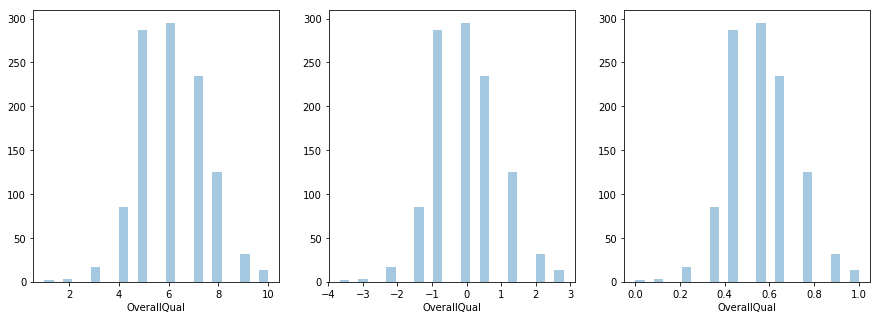

In [42]:
# Distribution of one concrete feature (an ordinal one)
f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(dt.OverallQual, kde = False, ax = axes[0])
sns.distplot(dt_s.OverallQual, kde = False, ax = axes[1])
sns.distplot(dt_m.OverallQual, kde = False, ax = axes[2])

In [43]:
# Run both models
print('Standardized data')
linreg(dt_s, dv_s)
print("----")
ridgereg(dt_s, dv_s)

print('\n======================\nMinMax normalized data')
linreg(dt_m, dv_m)
print("----")
ridgereg(dt_m, dv_m)

Standardized data
Linear regression root mean squared validation error: 103874459167938.34
Linear regression root mean squared train error: 18135.42237089548
----
     fun: 32360.573513997806
 message: 'Solution found.'
    nfev: 17
  status: 0
 success: True
       x: 19.136506749088127
Ridge regression root mean squared validation error: 26608.23552162119
Ridge regression root mean squared train error: 25017.909632982635

MinMax normalized data
Linear regression root mean squared validation error: 709099103949058.1
Linear regression root mean squared train error: 18187.64624896871
----
     fun: 32076.56627417585
 message: 'Solution found.'
    nfev: 19
  status: 0
 success: True
       x: 7.945285773335559
Ridge regression root mean squared validation error: 27198.33363671344
Ridge regression root mean squared train error: 25481.120083487313


Standardization was beneficial for Ridge regression but completely destroyed the results for linear regression.

## Feature selection
Feature selection can help to decrease the complexity of the model which:
* prevents overfitting
* helps to speedup training

### Find irelevant features - filter methods
First focus on the so called **filter methods** where we assess individual features, independently of other features, according to some quality measure (e.g. the variance, the correlation with the target variable,...). Filter methods are supposed to suppress the least interesting variables.

Some features are irrelevant just because of our **domain knowledge**.

In [45]:
# Drop Id - we will store all features to drop in the columns_to_remove list
columns_to_remove = ['Id']

#### Variance approach
Others can be detected as a variables with very **low variance**. It means that they are almost constant. 

Be careful, this is strongly influenced by previous transformations!

E.g. when standardization was applied - all variables have variance 1.

In [46]:
# Find features with low variance - we assume that they cannot help to infer the observable
# this makes sense especially for indicators
columns_to_remove = list(set(list(dt_s.columns[dt_s.var() < 0.01]) + columns_to_remove)) # note that after the standardization all non-indicator variables have variance 1
# note that for an indicator with true prob p is the var given by p*(1-p) - for p = 0.01 we have 0.0099

# top largest < 0.01
print(dt_s[columns_to_remove].var().nlargest(5))
# # top smallest
print(dt_s[columns_to_remove].var().nsmallest(5))
# # number of small ones
print(len(columns_to_remove))

Id                      1.000914
HouseStyle_2.5Unf       0.009954
MasVnrType_BrkCmn       0.009954
SaleCondition_Alloca    0.009954
Functional_Mod          0.009057
dtype: float64
Utilities_AllPub    0.000000
Condition2_RRNn     0.000000
Utilities_NoSeWa    0.000000
RoofMatl_Metal      0.000000
Condition2_RRAn     0.000913
dtype: float64
91


A more sophisticated approach is to study the relation of a feature to the target variable.

#### Correlation approach

Analysis of the correlation with the target variable. Note that Linear scaling of features doesn't influence the result.

In [47]:
# Correlation matrix Pearson & Spearman
corrP = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')
corrS = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='spearman')

In [50]:
# Pearson top 10 with target
corrP_cols = corrP.SalePrice.abs().nlargest(10).index
display(corrP.SalePrice.loc[corrP_cols])
# Spearman top 10 with target
corrS_cols = corrS.SalePrice.abs().nlargest(10).index
display(corrS.SalePrice.loc[corrS_cols])

SalePrice        1.000000
OverallQual      0.791963
SqrtGrLivArea    0.707052
GrLivArea        0.703866
GarageCars       0.645009
GarageArea       0.622276
Sqrt1stFlrSF     0.615341
1stFlrSF         0.615080
TotalBsmtSF      0.614957
ExterQual_TA    -0.574401
Name: SalePrice, dtype: float64

SalePrice         1.000000
OverallQual       0.810410
GrLivArea         0.735184
SqrtGrLivArea     0.735184
GarageCars        0.694128
GarageArea        0.648908
SqrtGarageArea    0.648908
YearBuilt         0.644751
FullBath          0.642719
GarageYrBlt       0.632785
Name: SalePrice, dtype: float64

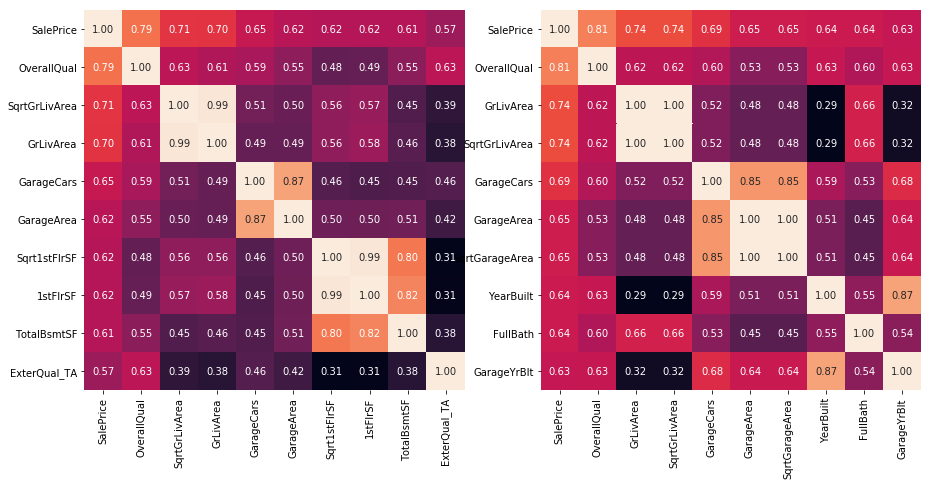

In [51]:
# Plot those correlations
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.heatmap(corrP.abs().loc[corrP_cols,corrP_cols],ax=axs[0], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrP_cols.values, xticklabels=corrP_cols.values)
sns.heatmap(corrS.abs().loc[corrS_cols,corrS_cols],ax=axs[1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrS_cols.values, xticklabels=corrS_cols.values)

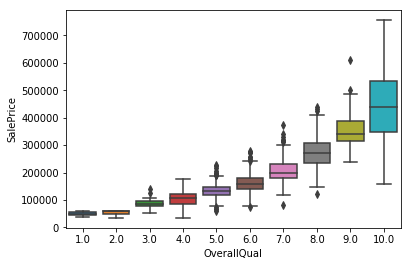

In [52]:
# OverallQual is an ordinal categorical variable stored in numbers
sns.boxplot(x='OverallQual', y='SalePrice', data=dt)

This can be used to remove features that are almost not correlated with the target variable. 

It makes sense for linear regression.

For non-linear models one has to be more careful since the correlation measures only the **linear** relation. They might be full functionally dependent (but not linearly) and have correlation 0.

In [53]:
# One can remove those with correlation smaller than some treshold.
additional_columns = list(corrP.SalePrice[corrP.SalePrice.abs() < 0.001].index)
print(additional_columns)
# extend columns_to_remove
columns_to_remove = list(set(columns_to_remove + additional_columns))

['BsmtFinSF2', 'BsmtHalfBath', 'Condition1_RRAn', 'Fence_GdPrv']


In [54]:
# Alternatively, if we don't want to set a treshold in correlation values (we don't know what value to choose)
# we can do the analogous selection based on p-values of statistical test about the zero correlation

# prepare data
X = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dt.SalePrice

# calculate F values for correlation coefficient (calculated from rho using an increasing function)
# calculate p-values of the correspondong F-test (inversely proportional to rho)
Fscores, pvals = feature_selection.f_regression(X,y)
pvals_result = pd.Series(pvals, index = X.columns)
print("5 largest P-values:")
display(pvals_result.nlargest(5))
print("5 smallest (absolute value) correlations:")
display(corrP.SalePrice.drop(columns_to_remove, errors = 'ignore').abs().nsmallest(5))

5 largest P-values:


LandContour_Lvl         0.925093
LotConfig_FR2           0.819261
BldgType_TwnhsE         0.762734
Neighborhood_SawyerW    0.736229
Heating_GasW            0.659390
dtype: float64

5 smallest (absolute value) correlations:


LandContour_Lvl         0.002845
LotConfig_FR2           0.006913
BldgType_TwnhsE         0.009133
Neighborhood_SawyerW    0.010191
Heating_GasW            0.013334
Name: SalePrice, dtype: float64

In [55]:
# One can remove those with p-value smaller than some treshold.
additional_columns = list(pvals_result[pvals_result > 0.8].index)
print(additional_columns)
# extend columns_to_remove
columns_to_remove = list(set(columns_to_remove + additional_columns))

['LandContour_Lvl', 'LotConfig_FR2']


#### T-test approach for indicator variables
For indicator variables we can measure if the value of the indicator influences the value of the target variable. If not, then it is probably not a relevant feature (especially for linear regression).

We shall use the t-test to check whether the value of a selected indicator influence on the mean of the target variable.

In [56]:
# Perform t-test with indicator variables - calculate p-values
ttest_pvals = df\
    .drop(columns_to_remove, axis = 1, errors = 'ignore')\
    .select_dtypes(include = ['uint8']).columns\
    .to_series()\
    .apply(lambda x: stats.ttest_ind(df.SalePrice[df[x] == 0], df.SalePrice[df[x] == 1], equal_var = False).pvalue)

# show largest and smallest p-values
display(ttest_pvals.nlargest(5))
display(ttest_pvals.nsmallest(4))

LotConfig_Corner        0.880203
BldgType_TwnhsE         0.853574
Heating_GasW            0.447864
Neighborhood_SawyerW    0.439773
Exterior2nd_BrkFace     0.435870
dtype: float64

KitchenQual_TA      8.315298e-95
ExterQual_TA        5.601284e-93
BsmtQual_TA         4.684438e-82
Foundation_PConc    2.762385e-79
dtype: float64

What does this mean?

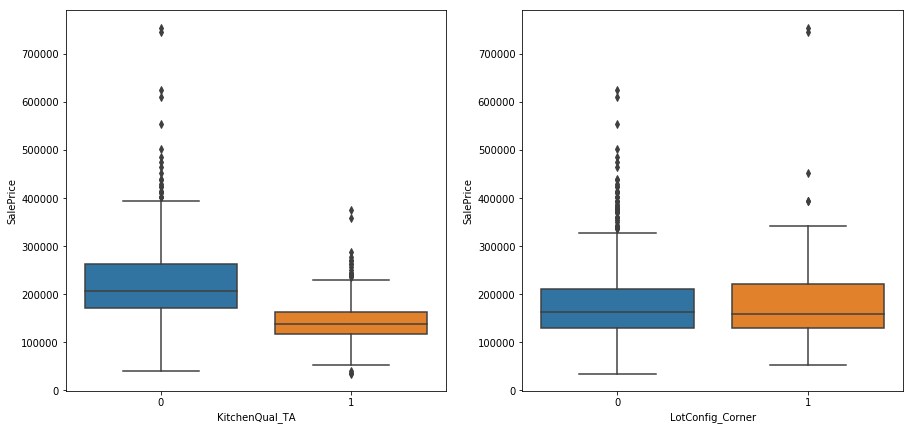

In [57]:
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.boxplot(x='KitchenQual_TA', y='SalePrice', data=dt,ax=axs[0])
sns.boxplot(x='LotConfig_Corner', y='SalePrice', data=dt,ax=axs[1])

We can see that small $p$-values corresponds to high differentiation in a target variable.

In [58]:
# Remove all larger than 50%
columns_to_remove = list(set(columns_to_remove + list(ttest_pvals[ttest_pvals > 0.6].index)))
print(len(columns_to_remove))

99


In [59]:
# Final removal from all datasets
dt.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dv.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dt_s.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dv_s.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dt_m.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dv_m.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dt.shape

(1095, 217)

In [60]:
# Run both models
linreg(dt, dv)
print("----")
ridgereg(dt, dv)

Linear regression root mean squared validation error: 29029.301244367176
Linear regression root mean squared train error: 23339.366889359335
----
     fun: 32862.53253440659
 message: 'Solution found.'
    nfev: 16
  status: 0
 success: True
       x: 10.40145826741964
Ridge regression root mean squared validation error: 27403.368735028776
Ridge regression root mean squared train error: 24589.86913119578


### Subset selection based on models - wrapper methods
Wrapper methods evaluate subsets of variables. Hence they can properly work with possible interactions between variables.
Moreover they are usually linked to the underlying learning algorithm.

The two main disadvantages of these methods are:
* The increasing overfitting risk when the number of observations is insufficient.
* The significant computation time when the number of variables is large.

Beacouse of the computional complexity usual aproaches are greedy ones.

A simple approach is a backward Recursive Feature Elimination (http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE ).

In [61]:
# Prepare the data
X = dt.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dt.SalePrice

used_columns = X.columns

# define the scorer which will be the RMSE
def scorer(Y, yp):
    return np.sqrt(metrics.mean_squared_error(Y, yp))

# prepare the model
clfM = linear_model.LinearRegression()

# prepare the backward selection algorithm (recursive feature elimination with cross validation)
selector = feature_selection.RFECV(clfM, step=1, cv=5, scoring=metrics.make_scorer(scorer))
# run it
selector = selector.fit(X, y)

# transform result to dataframe
result = pd.DataFrame({'Chosen': selector.support_, 'Ranking': selector.ranking_}, index=list(used_columns))
# columns to leave
columns_to_leave = result[result.Chosen == True].index
# show results
display(result[result.Chosen == False].head(5))
print('Chosen', len(columns_to_leave),'from ', result.Chosen.shape[0], 'features.')

,Chosen,Ranking
MSSubClass,False,2
LotArea,False,3


Chosen 214 from  216 features.


In [62]:
# Run both models
linreg(dt[list(columns_to_leave) + ['SalePrice']], dv[list(columns_to_leave) + ['SalePrice']])
print("----")
ridgereg(dt[list(columns_to_leave) + ['SalePrice']], dv[list(columns_to_leave) + ['SalePrice']])

Linear regression root mean squared validation error: 29034.065452922856
Linear regression root mean squared train error: 23340.30214991265
----
     fun: 32845.06168400428
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 10.195985144945473
Ridge regression root mean squared validation error: 27465.281806881914
Ridge regression root mean squared train error: 24575.257536166864


Other possibility is to use the L^1 regularization (Lasso) which produces sparse weights in the linear model.
Then we can select all features with non-zero coefficients.

In [63]:
# The Lasso - L^1 regularized regression to obtain a sparse solution
# Then the non-zero features may be extracted from the result.

# Prepare the data
X = dt.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dt.SalePrice

used_columns = X.columns

# We use the base estimator Lasso since the L1 norm promotes sparsity of features.
clf = linear_model.Lasso(alpha = 10, max_iter = 10000)

sfm = feature_selection.SelectFromModel(clf)
sfm.fit(X, y)

# transform result to dataframe
result = pd.DataFrame({'Chosen': sfm.get_support()}, index=list(used_columns))
# columns to leave
columns_to_leave = result[result.Chosen == True].index
# show results
display(result[result.Chosen == False].head(5))
print('Chosen', result.Chosen.sum(),'from ', result.Chosen.shape[0], 'features.')

/home/ladislav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Chosen
LotShape_Reg,False
LandSlope_Gtl,False
Neighborhood_BrkSide,False
Neighborhood_SawyerW,False
Condition1_Artery,False


Chosen 187 from  216 features.


In [64]:
# Run both models
linreg(dt[list(columns_to_leave) + ['SalePrice']], dv[list(columns_to_leave) + ['SalePrice']])
print("----")
ridgereg(dt[list(columns_to_leave) + ['SalePrice']], dv[list(columns_to_leave) + ['SalePrice']])

Linear regression root mean squared validation error: 28775.623089690984
Linear regression root mean squared train error: 23400.29941345537
----
     fun: 32531.969493330875
 message: 'Solution found.'
    nfev: 19
  status: 0
 success: True
       x: 7.867201466590661
Ridge regression root mean squared validation error: 27475.569402017132
Ridge regression root mean squared train error: 24429.143301340806


### Transformation of the target variable
It might be beneficial to transform the target variable as well. You should see the impact in the Homework.

/home/ladislav/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


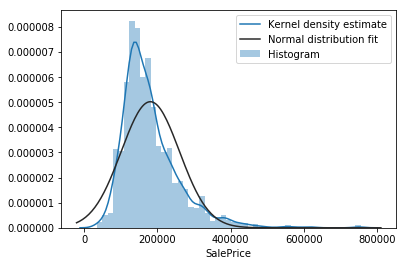

In [65]:
# Distribution of the target varaible
sns.distplot(df.SalePrice, 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram'},
             kde_kws = {'label': 'Kernel density estimate'},
             fit_kws = {'label': 'Normal distribution fit'},
            )

plt.legend()

We can see that the distribution is not normal.

Let's support this visual observation with a statistical test.

In [66]:
stats.normaltest(df.SalePrice)

NormaltestResult(statistic=610.8359109472653, pvalue=2.283848353787728e-133)

Since $p$-value is quite small, we can reject the null hypothesis that it has a normal distribution.

We can also estimate **skewness** as a measure of distributions asymetry and **kurtosis** as a measure of its "tailedness" (how the peak is sharped compared to how tails are long) in comparison to the normal distribution.

In [67]:
# Skewness and kurtosis as measures of asymetry and long tails
# Normal distribution has the Skewness = 0 and Kurtosis = 0 (Fisher's definition)
print('Skewness:', df.SalePrice.skew())
print('Kurtosis:', df.SalePrice.kurtosis())
# Again we see that the distribution is far from the normal distribution

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


We have some basic idea about the distribution of the target variable. Especially we see that it is not normal.

Let us now assume that we would like to use linear regression (possibly ridge) as a model to predict sale prices.
It is known (or can be easily found), the **least squares** method which is behind this model is actually equivalent to the maximum likelihood method when the target variable has a normal distribution.

Hence it is usually beneficial to transform the target variable in such a way that its new distribution will move 
towards the normal one.

In our case we can heuristically choose the logarithm.

Skewness: 0.12133506220520406
Kurtosis: 0.8095319958036296
NormaltestResult(statistic=25.507009834238303, pvalue=2.89216582205235e-06)


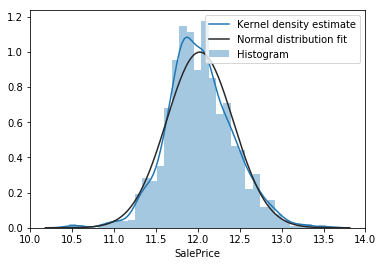

In [68]:
# observe the transformed distribution
sns.distplot(np.log(df.SalePrice), 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram'},
             kde_kws = {'label': 'Kernel density estimate'},
             fit_kws = {'label': 'Normal distribution fit'},
            )
plt.legend()

print('Skewness:', np.log(df.SalePrice).skew())
print('Kurtosis:', np.log(df.SalePrice).kurtosis())
 
print(stats.normaltest(np.log(df.SalePrice)))

It is not perfect but better that the original one.
So it should be worth trying it.

In [ ]:
# ukol pouze lin regrese
# roat mean square logaritmic error
